In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot4 as uproot
import scipy.stats
import sklearn
from sklearn import linear_model
from scipy import optimize
import warnings; warnings.simplefilter('ignore')

In [2]:
def get_gaussian_std(prediction,energy_bin_centers,oa_events):
    gfit = optimize.curve_fit(gaussian,energy_bin_centers,prediction)[0]
    loc,scale = gfit[0],gfit[1]
    return scale

def gaussian(x,loc,scale):
    with uproot.open("Fluxes.ND.root") as fFluxes :
        oa_flux = fFluxes['LBNF_numu_flux'].values()
        energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
        angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
    rescaling = oa_flux.max()
    return (1/(scale*((2*np.pi)**0.5)))*np.exp((-((x-loc)/scale)**2)/2)*rescaling

In [25]:
'''
loc = Center of the gaussian in GeV
scale = RMS of the gaussian in GeV
model = Regression model; default (Ridge) = Tikhonov
alpha = Regularisation parameter
'''

loc = 0.75
scale =  0.1
model = sklearn.linear_model.Ridge
alpha = 1e-12

In [26]:
# Get DUNE near detector muon neutrino flux as a function of off-axis angle
with uproot.open("Fluxes.ND.root") as fFluxes :
    oa_flux = fFluxes['LBNF_numu_flux'].values()
    energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
    angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
energy_bin_centers = np.add(energy_bins[:-1], energy_bins[1:])/2.
    
# Define target flux
target_loc = loc
target_scale = scale 
rescaling = oa_flux.max()
target_flux = [scipy.stats.norm.pdf(x, loc = target_loc, scale = target_scale)*rescaling for x in energy_bin_centers] #here we should scale the gaussian

# Calculate coefficients
if (model == None):
    x , residuals, rank, s = np.linalg.lstsq(oa_flux, target_flux, rcond=None)
    print("none")
else:
    lm = model(alpha=alpha,fit_intercept=False)
    lm.fit(oa_flux,target_flux)
    x = lm.coef_
    
print("Gaussian width: " + str(get_gaussian_std(lm.predict(oa_flux),energy_bin_centers,oa_flux)))

Gaussian width: 0.10379238620530035


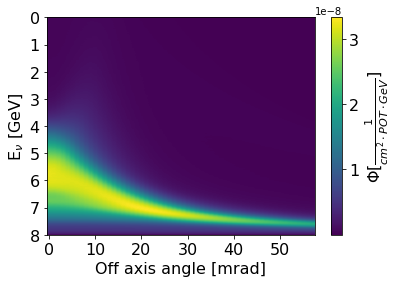

In [32]:
presentation_size = 16
norm = 277.6211684601875
plt.imshow(oa_flux/norm, aspect = "auto", origin = 'lower', extent = [angle_bins[0], angle_bins[-1], energy_bins[-1], energy_bins[0]])
plt.xlabel("Off axis angle [mrad]",fontsize=presentation_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r"E$_{\nu}$ [GeV]",fontsize=presentation_size)
cbar = plt.colorbar()
cbar.set_label(r'$\Phi [\frac{1}{cm^2\cdot POT\cdot GeV}]$',size=presentation_size)
cbar.ax.tick_params(labelsize=16)
plt.show()

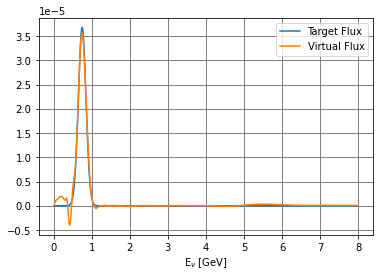

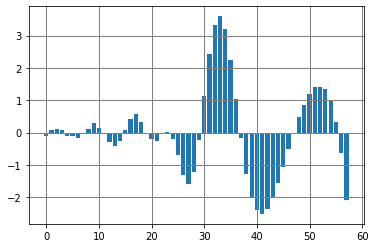

In [28]:
# Plot target flux, virtual flux
plt.plot(energy_bin_centers, target_flux, label = "Target Flux")
plt.plot(energy_bin_centers, lm.predict(oa_flux), label = "Virtual Flux")
plt.xlabel(r"E$_{\nu}$ [GeV]")

plt.legend();
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-")
plt.show()

# Plot coefficients
plt.bar(list(range(58)),x)
plt.grid(True, color = "grey", linewidth = "1", linestyle = "-")
plt.show()